In [1]:
#math
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [2]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([80]))


In [3]:
np.random.seed()
yn,xn,nobs = gen_data()

In [4]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,cc=False,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        self.cc = cc
        self.ols = ols
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = np.log(max(m.mean(),1e-4))
        if not self.cc:
            pr_m = stats.norm.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        s =  np.sqrt(sigma2)

        beta_jac = np.zeros(len(b))
        sigma_jac = 0
        
        #for censored
        if not cc and not ols: 
            left_stats = (y - np.dot(x, b)) / s
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x / s)
            beta_jac -= beta_left
            left_sigma = np.dot(left_frac*m, left_stats*m)
            sigma_jac -= left_sigma
        
        #for non-censored
        mid_stats = (y - np.dot(x, b)) / s
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) / s)
        beta_jac += beta_mid
        mid_sigma = ((np.square(mid_stats) - 1)*(1-m)).sum()
        sigma_jac += mid_sigma
        
        combo_jac = np.append(beta_jac, sigma_jac / (2*s) )  # by chain rule, since the expression above is dloglik/dlogsigma
        return combo_jac


model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Tobit Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1359.9
Model:                          Tobit   AIC:                             2724.
Method:            Maximum Likelihood   BIC:                             2734.
Date:                Wed, 30 Dec 2020                                         
Time:                        20:31:56                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0024      0.047     21.456      0.000       0.911       1.094
x1             0.2486      0.007     36.454      0.000       0.235       0.262
var            0.9423      0.044     21.352      0.000       0.856       1.029
==============================================================================
"""

# playing with eigenvalues

[-0.53162428 -0.24551161 -0.05741136  0.36302424  0.24004997  0.14905295]


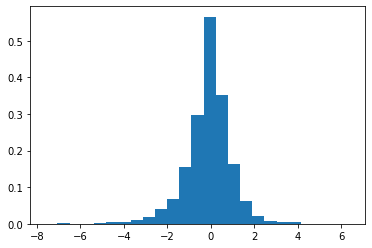

In [5]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    k1 = len(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    k2 = len(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2


def compute_eigen(yn,xn):
    ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
    hess1 = hess1/len(ll1)
    hess2 = hess2/len(ll2)
    
    k = k1 + k2
    n = len(ll1)
    
    #A_hat:
    A_hat1 = np.concatenate([hess1,np.zeros((k1,k2))])
    A_hat2 = np.concatenate([np.zeros((k2,k1)),-1*hess2])
    A_hat = np.concatenate([A_hat1,A_hat2],axis=1)

    #B_hat, covariance of the score...
    B_hat =  np.concatenate([grad1,-grad2],axis=1) #might be a mistake here..
    B_hat = np.cov(B_hat.transpose())
    #print(B_hat[0:3,3:])
    
    #compute eigenvalues for weighted chisq
    sqrt_B_hat= linalg.sqrtm(B_hat)
    W_hat = np.matmul(sqrt_B_hat,linalg.inv(A_hat))
    W_hat = np.matmul(W_hat,sqrt_B_hat)
    V,W = np.linalg.eig(W_hat)
    return V

n_sims = 5000
yn,xn,nobs = gen_data(beta0=1,beta1=.25)
model_eigs = compute_eigen(yn,xn)
print(model_eigs)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()

[ 5.76028002 -1.05797784 -0.60297691 -0.53931759  0.33677098  0.45416108]


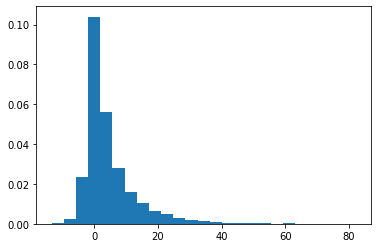

In [6]:
yn,xn,nobs = gen_data(beta0=1,beta1=1)
model_eigs = compute_eigen(yn,xn)
print(model_eigs)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()